## Imports and config

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import config as cfg

# Load and explore data

### Train sales

In [ ]:
train = pd.read_csv(cfg.FILENAMES['TRAIN_SALES'])
print(len(train))
train.head(2)

In [3]:
min(train["date"]), max(train["date"]) #wrong because str

('01.01.2013', '31.12.2014')

In [4]:
print(f"Number of items : {train['item_id'].nunique()}")
print(f"Number of shops : {train['shop_id'].nunique()}")

Number of items : 21807
Number of shops : 60


In [46]:
#item_cnt_day can be negative
sorted(list(set(train["item_cnt_day"])))[:5]

[-22.0, -16.0, -9.0, -6.0, -5.0]

In [5]:
train_1113 = train.loc[train["date"]=="01.01.2013",]
print(len(train_1113))
train_1113.head(2)

1669


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
7554,01.01.2013,0,19,18976,399.0,1.0
7644,01.01.2013,0,19,18284,199.0,1.0


In [6]:
print(f"Number of different items sold on 01/01/2013 : {train_1113['item_id'].nunique()}")
print(f"Total number of items sold on 01/01/2013: {train_1113['item_cnt_day'].sum()}")

Number of different items sold on 01/01/2013 : 1117
Total number of items sold on 01/01/2013: 1951.0


In [7]:
#Are there different prices for the same item?
max(train.groupby(by="item_id")["item_price"].nunique())
#Yes

1601

In [8]:
print("Most sold item :")
train.groupby(by="item_id").agg({"item_cnt_day":"sum"}).sort_values("item_cnt_day", ascending=False).head(1)

Most sold item :


,item_cnt_day
item_id,
20949,187642.0


##### Analyse most sold item

In [9]:
train_most_sold = train.loc[train["item_id"]==20949,]
train_most_sold = (train_most_sold.groupby(by="date")
                  .agg({"date_block_num":"first", "item_price":"mean", "item_cnt_day":"sum"})
                  .reset_index())
train_most_sold["date"] = pd.to_datetime(train_most_sold["date"], format = "%d.%m.%Y").dt.date
train_most_sold.head(2)

,date,date_block_num,item_price,item_cnt_day
0,2014-01-01,12,4.875000,139.0
1,2015-01-01,24,4.980769,168.0


/Users/robinblanchard/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


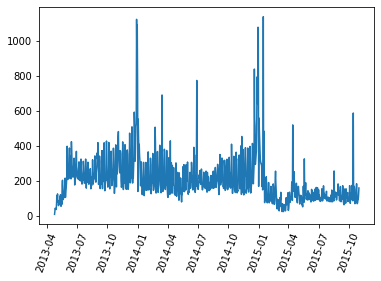

In [10]:
train_most_sold = train_most_sold.sort_values(by="date", ascending=True)
plt.plot(train_most_sold["date"], train_most_sold["item_cnt_day"])
plt.xticks(rotation=70)
plt.show()

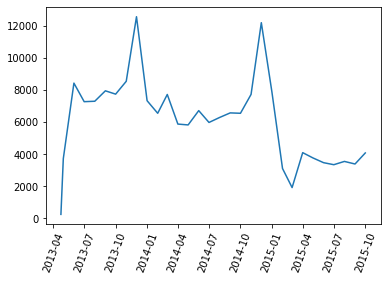

In [11]:
train_most_sold_month = (train_most_sold.groupby("date_block_num")
                         .agg({"date":"min",
                               "item_price":"mean",
                               "item_cnt_day":"sum"}))
plt.plot(train_most_sold_month["date"],train_most_sold_month["item_cnt_day"])
plt.xticks(rotation=70)
plt.show()

### Items

In [12]:
items = pd.read_csv(cfg.FILENAMES["ITEMS"])
print(len(items))
items.head(2)

22170


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


NLP on item_name?

### Item categories

In [18]:
categories = pd.read_csv(cfg.FILENAMES["ITEM_CATEGORIES"])
print(len(categories))
categories.head(8)

84


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7


Seems like video games products: games, accessories, maybe consoles. Create meta categories

In [31]:
items.groupby("item_category_id")["item_id"].count().sort_values(ascending=False).head()

item_category_id
40    5035
55    2365
37    1780
31    1125
58     790
Name: item_id, dtype: int64

In [34]:
categories.loc[categories["item_category_id"].isin([40,55,37,31,58])]

,item_category_name,item_category_id
31,Игры PC - Цифра,31
37,Кино - Blu-Ray,37
40,Кино - DVD,40
55,Музыка - CD локального производства,55
58,Музыка - Винил,58


### Shops

In [39]:
shops = pd.read_csv(cfg.FILENAMES["SHOPS"])
print(len(shops))
shops.head(2)

60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


Not relevant for first model

## Test

In [47]:
test = pd.read_csv(cfg.FILENAMES["TEST_SALES"])
print(len(test))
test.head(3)

214200


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


## Sample submission

In [48]:
sample = pd.read_csv(cfg.FILENAMES["SAMPLE_SUBM"])
print(len(sample))
sample.head()

214200


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## Deeper research

In [41]:
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


#### Is there some out-of-date shops/products?

In [52]:
train.groupby("date_block_num")["shop_id"].nunique()

date_block_num
0     45
1     46
2     46
3     46
4     45
5     46
6     46
7     45
8     45
9     46
10    45
11    46
12    46
13    46
14    48
15    49
16    49
17    49
18    50
19    51
20    50
21    52
22    50
23    50
24    50
25    47
26    46
27    47
28    44
29    43
30    43
31    42
32    43
33    44
Name: shop_id, dtype: int64

In [53]:
train.groupby("date_block_num")["item_id"].nunique()

date_block_num
0     8115
1     8168
2     8302
3     8145
4     8339
5     8478
6     8405
7     8031
8     7876
9     8039
10    8089
11    8474
12    7551
13    7134
14    7142
15    6774
16    6685
17    6681
18    6611
19    6363
20    6071
21    6334
22    6322
23    6605
24    6139
25    6053
26    6082
27    5476
28    5283
29    5216
30    5323
31    5108
32    5085
33    5413
Name: item_id, dtype: int64

In [60]:
print(len(set(train["item_id"])))
print(len(set(train.loc[train["date_block_num"]>21,"item_id"])))
items_last_year=set(train.loc[train["date_block_num"]>21,"item_id"])

21807
12174


In [64]:
print(len(set(train["shop_id"])))
print(len(set(train.loc[train["date_block_num"]>21,"shop_id"])))
shops_last_year=set(train.loc[train["date_block_num"]>21,"shop_id"])

60
54


In [79]:
print(len(set(test.loc[test["item_id"].isin([x for x in set(train["item_id"]) if x not in items_last_year]),"item_id"])))
print(len(set(test.loc[test["shop_id"].isin([x for x in set(train["shop_id"]) if x not in shops_last_year]),"item_id"])))

88
0


Some test items are out-of-date, but shops aren't

##### Decision : take all shops to train (not important), take all items (because the category may have an impact)

# Build train set

In [80]:
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [81]:
items.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [82]:
X_train = pd.merge(train, items, how="left", on="item_id")
print(X_train.isnull().sum())
X_train.head(2)

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_name           0
item_category_id    0
dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,03.01.2013,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,58


In [83]:
categories.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [84]:
X_train = pd.merge(X_train, categories, how="left", on="item_category_id")
print(X_train.isnull().sum())
X_train.head(2)

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил


In [86]:
X_train = pd.merge(X_train, shops, how="left", on="shop_id")
print(X_train.isnull().sum())
X_train.head(2)

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""


In [102]:
X_train["sales"] = X_train["item_price"] * X_train["item_cnt_day"]
X_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,sales
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",999.00
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",899.00
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",1099.00


In [108]:
X_train.to_csv(cfg.FILENAMES["X_TRAIN"])

# Decompose total sales

In [103]:
X_train_total = X_train.loc[X_train["item_cnt_day"]>=0,]
X_train_total = (X_train.groupby("date_block_num")
                .agg({"date":"min", "item_cnt_day":"sum", "sales":"sum"})
                .reset_index())
X_train_total.head(2)

,date_block_num,date,item_cnt_day,sales
0,0,01.01.2013,131479.0,91947091.13
1,1,01.02.2013,128090.0,90665707.37


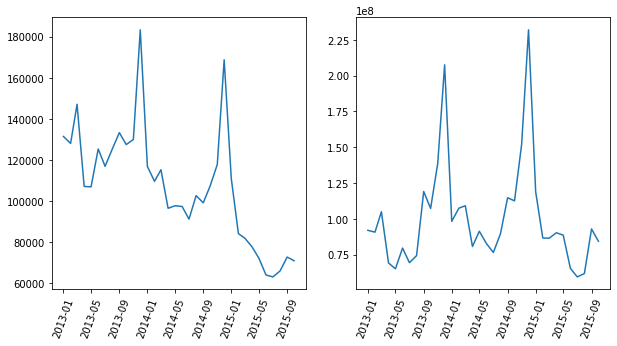

In [104]:
X_train_total["date"] = pd.to_datetime(X_train_total["date"], format="%d.%m.%Y")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(X_train_total["date"], X_train_total["item_cnt_day"])
plt.xticks(rotation=70)
plt.subplot(1,2,2)
plt.plot(X_train_total["date"], X_train_total["sales"])
plt.xticks(rotation=70)
plt.show()

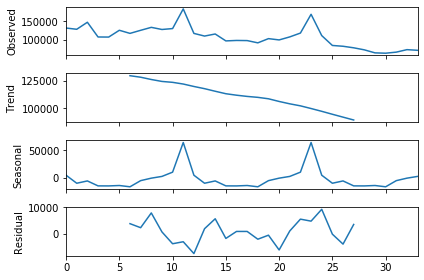

In [101]:
total_decompose = seasonal_decompose(X_train_total["item_cnt_day"], freq=12, model="additive")
total_decompose.plot()
plt.show()

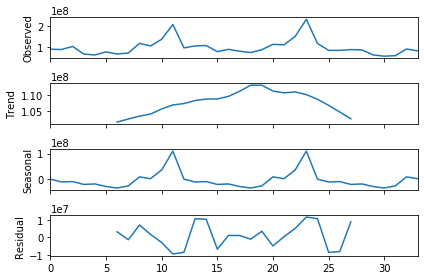

In [105]:
total_decompose = seasonal_decompose(X_train_total["sales"], freq=12, model="additive")
total_decompose.plot()
plt.show()

In [116]:
isinstance(X_train_total["date"].values[0], np.datetime64)

True